In [1]:
import sys
import os
import time
import warnings
import string

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapz
from statsmodels.tsa.stattools import acf 

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp
from utils import get_defect_list, get_defect_arr_from_frame, calc_weighted_mean
from AnalyseDefects_dev import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:


def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}', \
              suffix = "short", priority = 0, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}l', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path =  f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}vl', \
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    
    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def get_pair_corr_function(ar, ar_path, ball_window, frame_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, frame_interval[0], Nframes, archive_path=ar_path)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def get_pair_corr_from_defect_list(defect_list, ball_window, frame_idx_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40), save=False, save_dir=None, save_suffix=None):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(defect_list) if frame_idx_interval is None else frame_idx_interval[1] - frame_idx_interval[0]
    frame_interval = [0, Nframes - 1] if frame_idx_interval is None else frame_idx_interval

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[frame])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    if save:
        if save_dir is not None:
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        np.save(save_dir + f'rad_arr{save_suffix}.npy', rad_arr)
        np.save(save_dir + f'pcf_arr{save_suffix}.npy', pcf_arr)

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, method = 'fv', \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)


    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None, plot_norm = False):
    """
    Plot pair correlation function
    """
    if isinstance(pcf_estimated, pd.DataFrame):
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    if plot_norm:
        g = np.abs(g)

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, '-')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Initialize structure factor
    sf_arr = None

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method='fv', \
                                 Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr

def extract_pcf_results(data_path, Nframes = 181, Nexp = 10, subscript = '', savepath = None):
    """
    Analyse the defects for all the input folders
    """

    act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]
    act_dir_list = [os.path.join(data_path, os.listdir(data_path)[i]) for i in range(len(os.listdir(data_path)))]

    arrays_init = False

    print(act_list)
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):
        print(act)
        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            if not arrays_init:
                try:
                    rad_arr = np.load(os.path.join(exp_dir, 'rad_arr.npy'))
                    pcf_vals = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))

                    pcf_arr = np.nan * np.zeros((pcf_vals.shape[0], pcf_vals.shape[-1], len(act_list), len(exp_list)))
                    pcf_arr[:, :, i, j] = pcf_vals
                    arrays_init = True
                except:
                    continue
            else:
                try:
                    pcf_vals = np.load(os.path.join(exp_dir, 'pcf_arr.npy'))
                    pcf_arr[:, :, i, j] = pcf_vals

                except: 
                    continue
    print(pcf_arr.shape)
    if savepath is not None:
        np.save(os.path.join(savepath, f'rad.npy'), rad_arr)  
        np.save(os.path.join(savepath, f'pcf{subscript}.npy'), pcf_arr)
    if arrays_init:
        return rad_arr, pcf_arr
    else:
        return None, None
    
def get_pcf(obj, pcf_arr, LL, N, pcf_suffix = None, save = False):
    if LL == 512:
        subscript_list = ['', 'vl']
    elif LL == 1024:
        subscript_list = ['', 'l', 'vl']
    elif LL == 2048:
        subscript_list = ['', 'l']

    data_path = f'X:\\nematic_analysis\\na{LL}\\na{LL}{subscript_list[N]}_pcf{pcf_suffix}'
    act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]

    rad_arr_full = obj.get_sfac_pcf_full(N)[2]
    if max(act_list) > 0.024 and LL != 2048:
        rad_above24 = np.load(os.path.join(obj.output_paths[0], 'rad_above24.npy'))
    else:
        rad_above24 = None

    if 0:
        if LL == 1024:
            if N in [-1, 2]:
                conv_list = np.concatenate([obj.conv_list[-1],obj.conv_list[-2][:2]])
            else:
                idx = [i for i, val in enumerate(act_list) if val in obj.act_list[N]]
                conv_list = [obj.conv_list[N][i] for i in idx] 
        else:
            idx = [i for i, val in enumerate(act_list) if val in obj.act_list[N]]
            conv_list = [obj.conv_list[N][i] for i in idx]   

    idx = [i for i, val in enumerate(act_list) if val in obj.act_list[N]]
    conv_list = [obj.conv_list[N][i] for i in idx]  

    if save:
        savepath = os.path.join(obj.output_paths[N], f'pcf{pcf_suffix}_data.npz')
        np.savez(savepath, act_list = act_list, conv_list = conv_list, rad_arr_full = rad_arr_full, rad_above24 = rad_above24, pcf_arr = pcf_arr)

    return act_list, conv_list, rad_arr_full, rad_above24, pcf_arr

def calc_rad_cutoff(obj, N, L, cutoff=1e-2, rad_min=40, suffix='', unc_multiplier=10, tau_simple = True, save = False):

    pcf_path = os.path.join(obj.output_paths[N], f'pcf{suffix}_data.npz')
    pcf_dict = dict(np.load(pcf_path, allow_pickle=True))
    act_list, conv_list, rad_arr_full, rad_above24, pcf_arr = pcf_dict['act_list'], \
        pcf_dict['conv_list'], pcf_dict['rad_arr_full'], pcf_dict['rad_above24'], pcf_dict['pcf_arr']

    try:
        corr_time_arr = pcf_dict['corr_time_arr']
    except:
        corr_time_arr = None

    rad_cutoff_arr = np.nan * np.zeros((len(act_list), pcf_arr.shape[-1]))

    for i, act in enumerate(act_list):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if act > 0.024 and L!=2048:
                rad_arr = rad_above24
            else:
                rad_arr = rad_arr_full

            rad_idx_min = np.where(rad_arr > rad_min)[0][0]
            pcf_arr_av = np.nanmean(pcf_arr[conv_list[i]:, :, i, :], axis = (0)) - 1
            pcf_arr_av_std = np.nanstd(pcf_arr[conv_list[i]:, :, i, : ], axis = (0), ddof=1)
    
            for N in range(pcf_arr_av.shape[-1]):
                Nsamples = pcf_arr[conv_list[i]:,:,i,:].shape[0] * np.ones(len(rad_arr)) - np.nansum(np.isnan(pcf_arr[conv_list[i]:, :, i, N]),axis=0)
                
                if corr_time_arr is not None:
                    corr_time_idx = 1 if tau_simple else 0
                    pcf_std = pcf_arr_av_std[:,N] / np.sqrt((Nsamples / corr_time_arr[corr_time_idx, :, i,N]))
                else:
                    pcf_std = pcf_arr_av_std[:,N] / np.sqrt((Nsamples / unc_multiplier))
                try:
                    rad_cutoff_idx = np.where(np.abs(pcf_arr_av[rad_idx_min:, N]) - pcf_std[rad_idx_min:] < cutoff)[0][0] + rad_idx_min
                    rad_cutoff_arr[i, N] = rad_arr[rad_cutoff_idx]
                except:
                    pass
    if save:
        pcf_dict['rad_cutoff_arr'] = rad_cutoff_arr
        np.savez(pcf_path, **pcf_dict)
    return rad_cutoff_arr

def estimate_effective_sample_size(acf_vals, acf_err_vals = None, confint_vals = None, 
                                   max_lag=None, max_lag_threshold=0, 
                                   simple_threshold = 0.1, use_error_bound = True, use_abs_sum=False):
    """ acf_vals must not be non ie. start from steady state.
    if max_lag is None, the first lag where the confidence interval is below threshold is used.

    Returns tau, tau_simple
    """

    # If the error bound is not used, the acf values are used directly
    if use_error_bound:
        if acf_err_vals is None:
            val = confint_vals[:,0]
        else:
            val = acf_vals[:max_lag] - acf_err_vals[:max_lag] 
    else:
        val = acf_vals[:max_lag]

    # Calculate max lag if not provided
    if max_lag is None:       
        try:
            max_lag = np.where(val < max_lag_threshold)[0][0]
        except:
            return np.nan, np.nan

    # Calculate when the autocorrelation function is below the simple threshold
    try: 
        tau_simple = np.where(val < np.abs(simple_threshold))[0][0]
    except:
        tau_simple = np.nan
  
    # Sum the autocorrelation values
    if use_abs_sum:
        tau = 1 + 2 * np.sum(np.abs(acf_vals[1:max_lag]))
    else:
        tau = 1 + 2 * np.sum(acf_vals[1:max_lag])

    return tau, tau_simple

def calc_acf_for_arr(arr, conv_idx = 0, nlags = 0, alpha = 0.05, missing = 'conservative'):
    """
    arr shape must be (Nframes, Nexp) or (Nframes, Nsomething, Nexp)
    takes def arr and calculates the acf
    nlags = 0: calculate all lags
    """
    Nframes, Nexp = arr.shape[0], arr.shape[-1]
    Nsomething = arr.shape[1] if len(arr.shape) == 3 else None
    nlags = Nframes - conv_idx if nlags == 0 else min(Nframes - conv_idx, nlags)

    acf_arr = np.nan * np.zeros((Nframes + 1, *arr.shape[1:]))
    confint_arr = np.nan * np.zeros((Nframes + 1, 2, *arr.shape[1:]))

    if Nsomething:
        for i in range(Nsomething):
            for j in range(Nexp):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    acf_res, confint = acf(arr[conv_idx:,i,j], nlags = nlags, alpha = alpha)
                    acf_arr[-(nlags + 1):, i, j] = acf_res
                    confint_arr[-(nlags + 1):, :, i, j] = confint
    else:
        for i in range(Nexp):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)

                acf_res, confint = acf(arr[conv_idx:,i], nlags = nlags, alpha = alpha, missing=missing)
                acf_arr[-(nlags + 1):, i] = acf_res
                confint_arr[-(nlags + 1):, :, i] = confint
    return acf_arr, confint_arr

def calc_corr_time(npz_dict, npz_target_name, npz_path, use_error_bound = True,
                    acf_dict = {'nlags_frac': 0.5, 'max_lag': None, 'alpha': 0.3174, 'max_lag_threshold': 0, 'simple_threshold': 0.1},
                    save = True):  
    """ npz_obj is the npz file containing the target array
    target array must have shape (Nframes, Nact, Nexp) or (Nframes, Nsomething, Nact, Nexp)
    """
    
    arr = npz_dict[npz_target_name]
    act_list = npz_dict['act_list']
    conv_list = npz_dict['conv_list']
    print(act_list)
    print(conv_list)
    print(arr.shape)

    corr_time_arr = np.zeros((2, *arr.shape[1:],)) 
    Nsomething = arr.shape[1] if len(arr.shape) == 4 else None

    max_lag = acf_dict['max_lag']
    alpha = acf_dict['alpha']
    max_lag_threshold = acf_dict['max_lag_threshold']
    simple_threshold = acf_dict['simple_threshold']

    for j, act in enumerate(act_list):
        act_idx = act_list.index(act) if type(act_list) is list else np.where(act_list == act)[0][0]

        conv_idx = conv_list[act_idx]
        nf = arr.shape[0] - conv_idx
        nlags= int(nf * acf_dict['nlags_frac'])  
    
        arr_vals =  arr[:, :, act_idx, :] if Nsomething else arr[:, act_idx, :]
        acf_arr, confint_arr = calc_acf_for_arr(arr_vals, conv_idx = conv_idx, nlags = nlags, alpha = alpha)

        if Nsomething:
            for k in range(arr.shape[-1]):
                for i in range(arr.shape[1]):
                    acf_vals = acf_arr[-(nlags + 1):, i, k]
                    confint_vals = confint_arr[-(nlags + 1):, :, i, k]

                    tau, tau_simple = estimate_effective_sample_size(acf_vals,
                                                                confint_vals = confint_vals, 
                                                                max_lag = max_lag, 
                                                                max_lag_threshold = max_lag_threshold, 
                                                                simple_threshold = simple_threshold,
                                                                use_error_bound = use_error_bound)    
                    corr_time_arr[:, i, j, k] = [tau, tau_simple,]
        else:
            for k in range(arr.shape[-1]):
                acf_vals = acf_arr[- (nlags + 1):,k]
                confint_vals = confint_arr[- (nlags + 1):,:,k]

                tau, tau_simple = estimate_effective_sample_size(acf_vals,
                                                            confint_vals = confint_vals, 
                                                            max_lag = max_lag, 
                                                            max_lag_threshold = max_lag_threshold, 
                                                            simple_threshold = simple_threshold,
                                                            use_error_bound = use_error_bound)   
                corr_time_arr[:, j, k] = [tau, tau_simple,]
    if save:
        npz_dict['corr_time_arr'] = corr_time_arr 
        np.savez(npz_path, **npz_dict)
    return corr_time_arr

In [110]:
extract = True

LL = 2048
sub = 'r2' if LL == 2048 else ''
output_path = f'data\\na{LL}'
mode = 'all' # 'all' or 'short'
defect_dir_list = gen_analysis_dict(LL, mode)
ad = AnalyseDefects(defect_dir_list, output_path=output_path)

if extract:
    subscript_list = ['', 'l'] if LL == 2048 else ['', 'l', 'vl']
    Nframes_list = [181, 400] if LL == 2048 else [181, 400, 1500]
    Nexp = [10, 5] if LL == 2048 else [10, 10, 10]

    for i, subscript in enumerate(subscript_list):

        save_path = ad.output_paths[i]  
        data_path = f'X:\\nematic_analysis\\na{LL}\\na{LL}{subscript}_pcf{sub}'

        act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]
        act_dir_list = [os.path.join(data_path, os.listdir(data_path)[i]) for i in range(len(os.listdir(data_path)))]
        rad_arr, pcf_arr = extract_pcf_results(data_path, Nframes = Nframes_list[i], \
                                               Nexp = Nexp[i], subscript=sub, savepath = save_path)  

        print(f"Saved data for {LL}{subscript}") 

[0.023, 0.024, 0.025, 0.028, 0.03, 0.034, 0.05]
0.023
0.024
0.025
0.028
0.03
0.034
0.05
(181, 513, 7, 10)
Saved data for 2048
[0.019, 0.0195, 0.02, 0.021, 0.0215, 0.022, 0.0225]
0.019
0.0195
0.02
0.021
0.0215
0.022
0.0225
(401, 513, 7, 5)
Saved data for 2048l


In [123]:
LL = 2048
N = -1
pcf_suffix='r2' if LL == 2048 else ''

load = True
calculate_corr_time = False
calculate_cutoff = True

tau_simple = True
use_error_bound = False
acf_dict = {'nlags_frac': 0.5, 'max_lag': None, 'alpha': 0.3174, 'max_lag_threshold': 0, 'simple_threshold': 0.15}

cutoff = 10e-3
rad_list = [10, 10, 30] if LL == 1024 else [10, 30]
Nrange = [0, 1, 2] if LL == 1024 else [0, -1]

output_path = f'data\\na{LL}'
mode = 'all' # 'all' or 'short'
defect_dir_list = gen_analysis_dict(LL, mode)
ad = AnalyseDefects(defect_dir_list, output_path=output_path)

if load:
    pcf_path = os.path.join(ad.output_paths[N], f'pcf{pcf_suffix}_data.npz')
    pcf_data = np.load(pcf_path, allow_pickle=True)
    act_list, conv_list, rad_arr_full, rad_above24, pcf_arr = pcf_data['act_list'], \
        pcf_data['conv_list'], pcf_data['rad_arr_full'], pcf_data['rad_above24'], pcf_data['pcf_arr']
else:
    for N in Nrange:
        pcf_arr = np.load(os.path.join(ad.output_paths[N], f'pcf{pcf_suffix}.npy'))
        get_pcf(ad,pcf_arr, LL, N, pcf_suffix=pcf_suffix, save=True)
        #print(pccf.shape)
if calculate_corr_time:
    for N in Nrange:
        pcf_path = os.path.join(ad.output_paths[N], f'pcf{pcf_suffix}_data.npz')
        pcf_dict = dict(np.load(pcf_path, allow_pickle=True))
        calc_corr_time(npz_dict=pcf_dict, npz_target_name='pcf_arr', npz_path=pcf_path, 
                                use_error_bound=use_error_bound, 
                                acf_dict=acf_dict, 
                                save = True)
if calculate_cutoff:
    for N in Nrange:
        calc_rad_cutoff(ad, N, LL, cutoff = cutoff, rad_min=rad_list[N], suffix=pcf_suffix, tau_simple = tau_simple, save = True)

In [124]:
pcf_data.files

['act_list',
 'conv_list',
 'rad_arr_full',
 'rad_above24',
 'pcf_arr',
 'corr_time_arr',
 'rad_cutoff_arr']

In [ ]:
fig, ax = plt.subplots()
act_min_idx = [(0, 0, 2), (0, 0)]
for i, LL in enumerate([1024, 2048]):

    output_path = f'data\\nematic_analysis{LL}_LL0.05'
    mode = 'all' # 'all' or 'short'
    defect_dir_list = gen_analysis_dict(LL, mode)
    ad = AnalyseDefects(defect_dir_list, output_path=output_path)

    for N in range(ad.Ndata):
        pcf_path = os.path.join(ad.output_paths[N], 'pcf_data.npz')
        pcf_data = np.load(pcf_path, allow_pickle=True)
        act_list = pcf_data['act_list'][act_min_idx[i][N]:]
        rad_cutoff_arr = pcf_data['rad_cutoff_arr'][act_min_idx[i][N]:]
       # print(rad_cutoff_arr)
        print(rad_cutoff_arr,)
        ax.errorbar(act_list, np.nanmean(rad_cutoff_arr, axis = 1), 
                    np.nanstd(rad_cutoff_arr, axis = 1) / np.sqrt(np.nansum(rad_cutoff_arr>0,axis=1)),
                    label = f'L = {LL}' if N == 0 else None, fmt='o', alpha = .7, color = 'C0' if LL == 1024 else 'C1')
ax.set_xlim(0.018,0.051)
ax.legend() 

In [ ]:
unc_multiplier = 10
cutoff = 1e-2
rad_idx_min = np.where(rad_arr_full > 40)[0][0]
save = True

rad_cutoff_arr = np.nan * np.zeros((len(act_list), pcf_arr.shape[-1]))

fig, ax = plt.subplots()

for i, act in enumerate(act_list):
    pcf_arr_av = np.nanmean(pcf_arr[conv_list[i]:, :, i, :], axis = (0)) - 1
    pcf_arr_av_std = np.nanstd(pcf_arr[conv_list[i]:, :, i, : ], axis = (0), ddof=1)
    rad_cutoff_arr = np.zeros(pcf_arr_av.shape[-1])

    for N in range(pcf_arr_av.shape[-1]):

        Nsamples = pcf_arr[conv_list[i]:,:,i,:].shape[0] * np.ones(len(rad_arr_full)) - np.nansum(np.isnan(pcf_arr[conv_list[i]:, :, i, N]),axis=0)
        pcf_std = pcf_arr_av_std[:,N] / np.sqrt((Nsamples / unc_multiplier))
 
        try:
            rad_cutoff_idx = np.where(np.abs(pcf_arr_av[rad_idx_min:, N]) - pcf_std[rad_idx_min:] < cutoff)[0][0] + rad_idx_min
            rad_cutoff_arr[i, N] = rad_arr_full[rad_cutoff_idx]
        except:
            rad_cutoff = np.nan
            print(f'No cutoff found for N = {N}')
            print("min val:", np.nanmin(np.abs(pcf_arr_av[rad_idx_min:,N])), np.nanmean(pcf_std[rad_idx_min:]))
    print(rad_cutoff_arr, rad_cutoff_arr[rad_cutoff_arr>0].mean(), rad_cutoff_arr[rad_cutoff_arr>0].std()/np.sqrt(len(rad_cutoff_arr[rad_cutoff_arr>0]))) 
    ax.errorbar(act, rad_cutoff_arr[rad_cutoff_arr>0].mean(), rad_cutoff_arr[rad_cutoff_arr>0].std()/np.sqrt(len(rad_cutoff_arr[rad_cutoff_arr>0])), fmt='o', color='black')

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9872\3578830893.py:108: RuntimeWarning: Mean of empty slice
  rad_cutoff = np.nanmean(rad_cutoff_arr, axis = 1)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


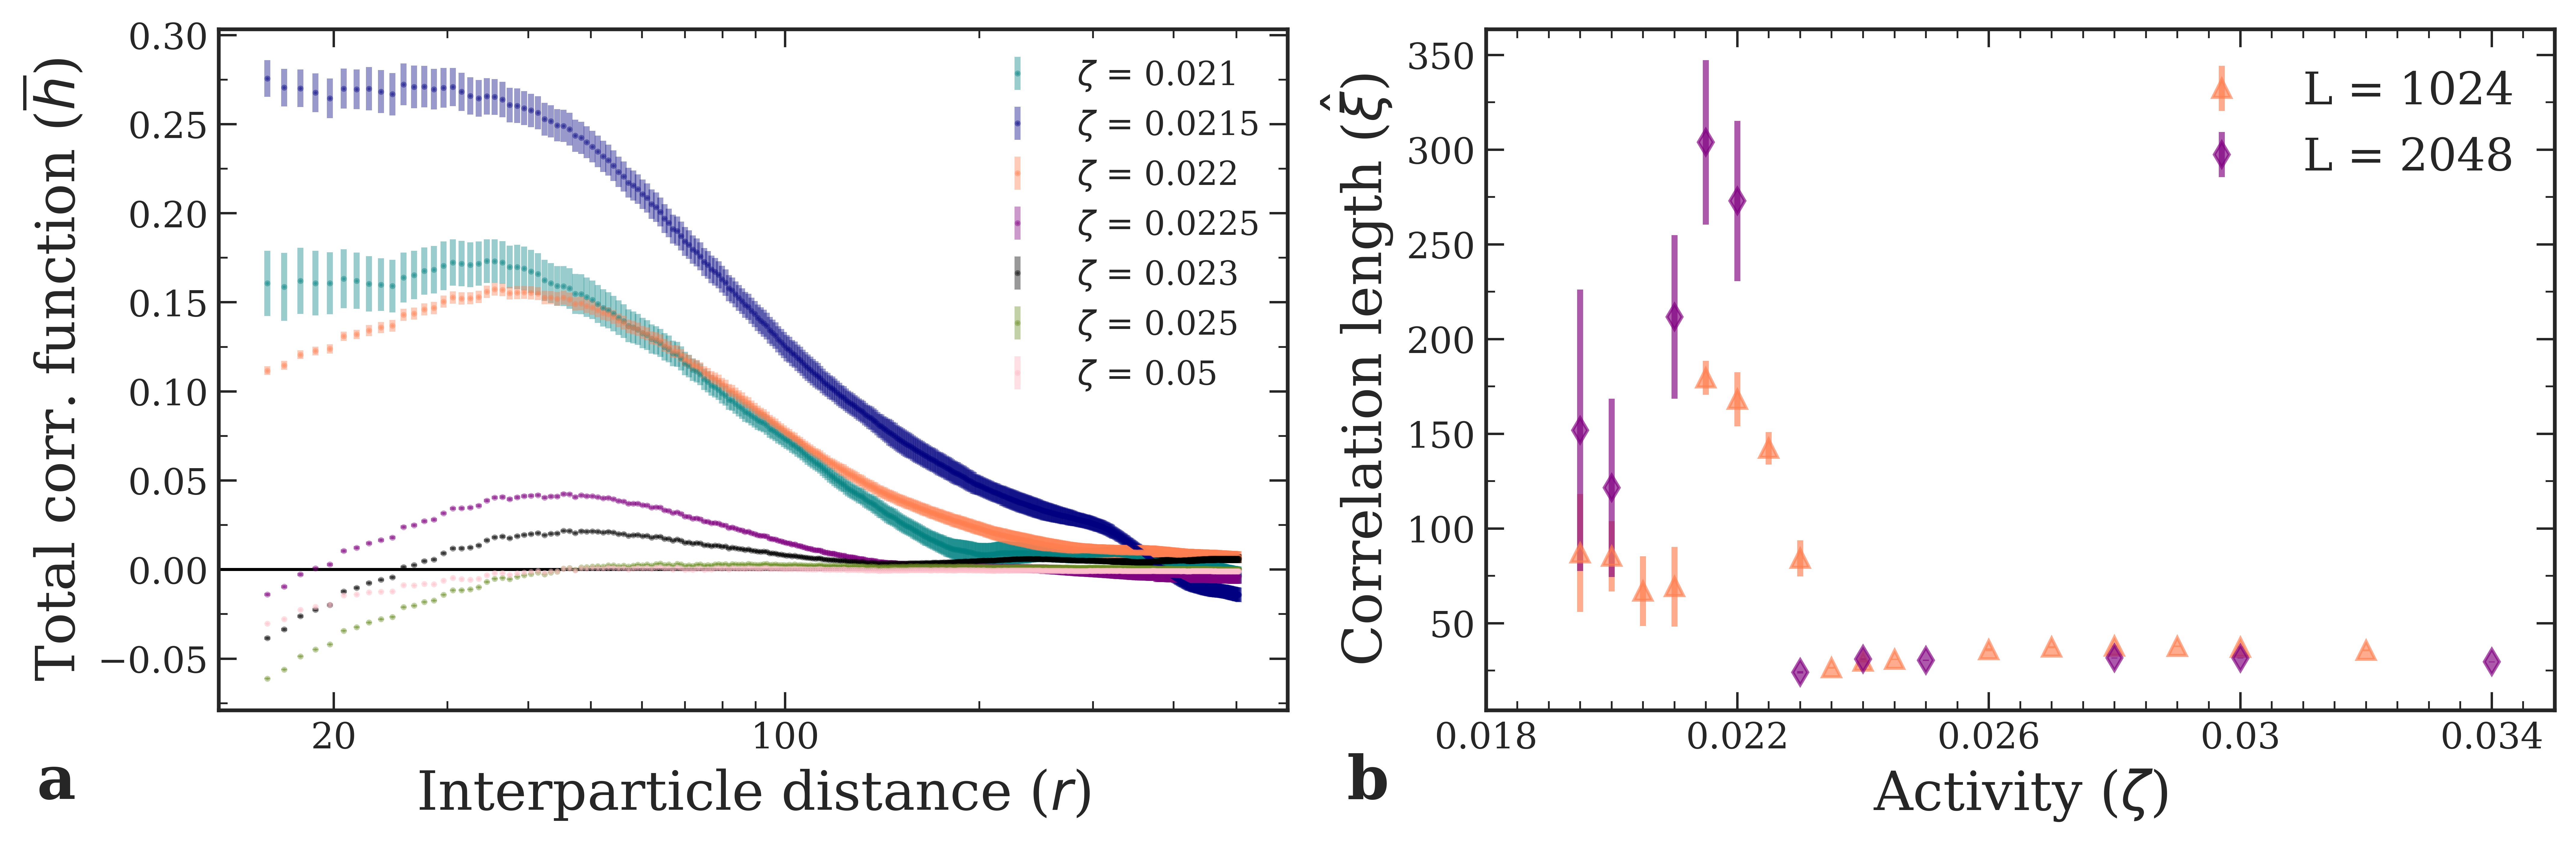

In [21]:
LL = 2048
pcf_suffix='r2'
output_path = f'data\\na{LL}'
mode = 'all' # 'all' or 'short'
defect_dir_list = gen_analysis_dict(LL, mode)
ad = AnalyseDefects(defect_dir_list, output_path=output_path)

plot_corr_len_all = True
use_abs = False
normalize = False
unc_multiplier = 10

rad_idx_list = [40, 60, 40]
rad_list = [30, 15]
N_list = [-1,-2,]
Nexp = [10, 5]
Nframes_list = [181, 400]
subscript_list = ['', 'l']
act_min, act_max = 0.0201, 0.0501
cutoff = 1e-2

fig, ax = plt.subplots(1, ncols=2, figsize=(12, 4))  


for j, N in enumerate(N_list):

    pcf_path = os.path.join(ad.output_paths[N], f'pcf{pcf_suffix}_data.npz')
    pcf_data = np.load(pcf_path, allow_pickle=True)
    act_list, conv_list, rad_arr_full, rad_above24, pcf_arr = pcf_data['act_list'], \
        pcf_data['conv_list'], pcf_data['rad_arr_full'], pcf_data['rad_above24'], pcf_data['pcf_arr']
    corr_time_arr = pcf_data['corr_time_arr']
    rad_cutoff_arr = pcf_data['rad_cutoff_arr']
    activities = act_list

    for i, act in enumerate(activities):
        if act < act_min or act > act_max or act in [0.03, 0.034, 0.024,0.028]:
            continue
        
        act_idx = i #act_list.index(act)
        rad_arr = rad_above24 if act > 0.024 and LL != 2048 else rad_arr_full
        ff_idx = conv_list[i]
        #pcf_arr = pcf_arr_full[:, :, i, :]

        with warnings.catch_warnings(): 
            warnings.simplefilter("ignore", category=RuntimeWarning)
            pcf_arr_av = np.nanmean(pcf_arr[ff_idx:, :, i, :], axis = (0,-1)) - 1
            pcf_arr_av_orig = pcf_arr_av.astype('float') 
            pcf_arr_av = np.abs(pcf_arr_av) if use_abs else pcf_arr_av

       
            Nsamples = pcf_arr[conv_list[i]:,:,i,:].shape[0] * np.ones((len(rad_arr), pcf_arr.shape[-1])) - np.nansum(np.isnan(pcf_arr[conv_list[i]:, :, i, :]),axis=(0))

            pcf_arr_av_std = np.nanstd(pcf_arr[ff_idx:, :, i, :], axis = (0,-1), ddof=1)  \
                            / np.sqrt(np.nansum(Nsamples / corr_time_arr[1, :, i, :], axis = -1))

        rad_min=rad_list[j]
        rad_idx_min = np.where(rad_arr > rad_min)[0][0]
        rad_idx_min_norm=np.where(rad_arr > rad_list[-1])[0][0]

        if normalize:
            pcf_arr_av[rad_idx_min_norm:, act_idx] = pcf_arr_av[rad_idx_min_norm:, act_idx] / np.abs(pcf_arr_av[rad_idx_min_norm, act_idx])
            pcf_arr_av_std[rad_idx_min_norm:, act_idx] = pcf_arr_av_std[rad_idx_min_norm:, act_idx] / np.abs(pcf_arr_av[rad_idx_min_norm, act_idx])

        kwargs = {'alpha': .4, 'label': rf'$\zeta$ = {act}'}
        if act < act_max:
            if act == 0.023:
                color = 'k'
                kwargs.update({'color': color})
            elif act == 0.025:
                color = 'olivedrab'
                kwargs.update({'color': color})
            elif act == 0.05:
                color = 'pink'
                kwargs.update({'color': color, 'alpha': .5})

            ax[0].errorbar(rad_arr[rad_idx_min_norm:], 
                            pcf_arr_av[rad_idx_min_norm:,], fmt='.', ms=2,
                            yerr=pcf_arr_av_std[rad_idx_min_norm:,],\
                            **kwargs)
        else:
            pass
  
        if not plot_corr_len_all:
            rad_cutoff = np.nanmean(rad_cutoff_arr[i],)
            rad_cutoff_sem = np.nanstd(rad_cutoff_arr[i],) / np.sqrt(np.nansum(rad_cutoff_arr[i]>0,))
            rad_cutoff_idx = np.where(rad_arr > rad_cutoff)[0][0]
            pcf_cutoff = pcf_arr_av[rad_cutoff_idx,]

            ax[1].errorbar(act, rad_cutoff, rad_cutoff_sem,
                    label = f'L = {LL}' if N == 0 else None, 
                    fmt='o', alpha = .7, color = 'r' if pcf_cutoff > 0 else 'k')

if plot_corr_len_all:
    color = ['r','g','b', 'k']
    marker = ['o','s','^','d']

    for i, LL in enumerate([1024, 2048]):
        output_path = f'data\\nematic_analysis{LL}_LL0.05'
        mode = 'all'
        defect_dir_list = gen_analysis_dict(LL, mode)
        ad = AnalyseDefects(defect_dir_list, output_path=output_path)

        for N in range(ad.Ndata):
            pcf_path = os.path.join(ad.output_paths[N], 'pcf_data.npz')
            pcf_data = np.load(pcf_path, allow_pickle=True)
            act_list, rad_cutoff_arr = pcf_data['act_list'], pcf_data['rad_cutoff_arr']

            rad_cutoff = np.nanmean(rad_cutoff_arr, axis = 1)
            rad_cutoff_sem = np.nanstd(rad_cutoff_arr, axis = 1) / np.sqrt(np.nansum(rad_cutoff_arr>0, axis=1))

            ax[1].errorbar(act_list, rad_cutoff, rad_cutoff_sem,
                    label = f'L = {LL}' if N == 0 else None, 
                    fmt=marker[2+i], alpha = .65, color = f'C{2+i}')
    ax[1].legend()

xticks = [0.018, 0.022, 0.026, 0.030, 0.034]
ax[1].set_xticks(xticks,xticks)
ax[0].set_xticks([10,100], [10,100])
# ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.0005))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(25))

    # marker = 'o' #if pcf_cutoff > 0 else '_'
    # color = 'r' if pcf_cutoff > 0 else 'k'
    # ms = 10
    # ax[1].plot(act, rad_cutoff, marker, color=color, alpha=.4,ms=ms,)

#ax[0].set_xlim(xmin=9)
ax[0].set_ylabel(r'Total corr. function ($\overline{h}$)')
ax[0].set_xlabel(r'Interparticle distance ($r$)')
ax[0].legend(fontsize=11,ncols=1) 
ax[0].hlines(0, 0, rad_arr_full[-1], linestyles='solid', colors='k', lw=1)

ax[1].set_xlim(0.018,0.035)
ax[1].set_ylabel(r'Correlation length ($\hat{\xi}$)')
ax[1].set_xlabel(r'Activity ($\zeta$)');
ax[0].set_xscale('log') 
ax[0].set_xticks([20,100], [20,100])

for n, axx in enumerate(ax):
    ax[n].text(-0.17 if n==0 else -0.13, -.13, string.ascii_lowercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')
fig.dpi = 720
fig.tight_layout()

In [ ]:
LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'
defect_dir_list = gen_analysis_dict(LL, mode)
ad = AnalyseDefects(defect_dir_list, output_path=output_path)

#N_list = [-1,-2,] if LL == 2048 else [-1,-2,-3]  
unc_multiplier = 10

#subscript_list = ['vl', 'l', '']
rad_idx_list = [40, 60, 40]
#rad_list = [30, 15, 10]
if LL == 1024:
    rad_list = [30, 15, 10]
    N_list = [-1,-2,-3]
    Nexp = [10, 10, 10]
    Nframes_list = [181, 400, 1500]
    subscript_list = ['', 'l', 'vl']
    act_min, act_max = 0.0201, 0.05
    cutoff = 1e-2
elif LL == 2048:
    rad_list = [30, 15]
    N_list = [-1,-2,]
    Nexp = [10, 5]
    Nframes_list = [181, 400]
    subscript_list = ['', 'l']
    act_min, act_max = 0.0191, 0.05
    cutoff = 6e-3
elif LL == 512:
    rad_list = [20, 10]
    N_list = [-1,0,]
    Nexp = [10, 10]
    Nframes_list = [181, 1500]
    subscript_list = ['', 'vl']
    act_min, act_max = 0.0201, 0.05
    cutoff = 1e-1

use_abs = False
normalize = False
#cutoff = 1e-2 #1e-2

fig, ax = plt.subplots(nrows = len(N_list)+1, ncols=2, figsize=(10, 15))  
#ax = ax.flatten()

for j, N in enumerate(N_list[:]):

    act_list, conv_list, rad_arr_full, rad_above24, pcf_arr = get_pcf(ad,LL,N)  
    activities = act_list

    for i, act in enumerate(activities):
        if act < act_min or act > act_max:
            continue
        
        act_idx = act_list.index(act)
        rad_arr = rad_above24 if act > 0.024 else rad_arr_full
        ff_idx = conv_list[i]

        with warnings.catch_warnings(): 
            warnings.simplefilter("ignore", category=RuntimeWarning)
            pcf_arr_av = np.nanmean(pcf_arr[ff_idx:], axis = (0,-1)) - 1
            pcf_arr_av_orig = pcf_arr_av.astype('float') 
            pcf_arr_av = np.abs(pcf_arr_av) if use_abs else pcf_arr_av
            Nsamples = pcf_arr[ff_idx:].size - np.isnan(pcf_arr[ff_idx:].flatten()).sum()
            pcf_arr_av_std = np.nanstd(pcf_arr[ff_idx:], axis = (0,-1), ddof=1)  \
                            / (Nsamples / unc_multiplier)

        rad_min=rad_list[j]
        rad_idx_min = np.where(rad_arr > rad_min)[0][0]
        #rad_idx_min = 50
        rad_idx_min_norm=np.where(rad_arr > rad_list[-1])[0][0]

        area = trapz(pcf_arr_av[rad_idx_min_norm:, act_idx], rad_arr[rad_idx_min_norm:])
        if normalize:
            pcf_arr_av[rad_idx_min_norm:, act_idx] = pcf_arr_av[rad_idx_min_norm:, act_idx] / area #pcf_arr_av[rad_idx_min_norm, act_idx]
            pcf_arr_av_std[rad_idx_min_norm:, act_idx] = pcf_arr_av_std[rad_idx_min_norm:, act_idx] / area #pcf_arr_av[rad_idx_min_norm, act_idx]

     #   ax[j, 0].plot(rad_arr[rad_idx_min_norm:], pcf_arr_av[rad_idx_min_norm:, act_idx], label = rf'$\zeta$ = {act}', alpha=.65)
        ax[j,0].errorbar(rad_arr[rad_idx_min_norm:], 
                         pcf_arr_av[rad_idx_min_norm:, act_idx], 
                         yerr=pcf_arr_av_std[rad_idx_min_norm:, act_idx], alpha=.65, label = rf'$\zeta$ = {act}')
        if len(np.where(np.abs(pcf_arr_av[rad_idx_min:, act_idx]) - pcf_arr_av_std[rad_idx_min:, act_idx] < cutoff)[0]) == 0:
            rad_cutoff_idx = np.argmin(np.abs(pcf_arr_av[rad_idx_min:, act_idx])) + rad_idx_min
            rad_cutoff = rad_arr[rad_cutoff_idx]
            pcf_cutoff = pcf_arr_av[rad_cutoff_idx, act_idx]
            print(act, rad_cutoff, pcf_cutoff - pcf_arr_av_std[rad_cutoff_idx, act_idx])
            print(np.nanmin(pcf_arr_av[rad_idx_min:,act_idx]))
        else:
            rad_cutoff_idx = np.where(np.abs(pcf_arr_av[rad_idx_min:, act_idx]) - pcf_arr_av_std[rad_idx_min:, act_idx] < cutoff)[0][0] + rad_idx_min
            rad_cutoff = rad_arr[rad_cutoff_idx]
            pcf_cutoff = pcf_arr_av[rad_cutoff_idx, act_idx]
    
        marker = '+' if pcf_cutoff > 0 else '_'
        color = 'r' if pcf_cutoff > 0 else 'k'
        ms = 10 if pcf_cutoff > 0 else 5
        ax[j, 1].plot(act, rad_cutoff, marker, color=color, alpha=.4,ms=ms,)

        ax[-1, 0].plot(rad_arr[np.where(rad_arr > rad_list[-1])[0][0]:], pcf_arr_av_orig[np.where(rad_arr > rad_list[-1])[0][0]:, act_idx], label = rf'$\zeta$ = {act}', alpha=.65)
        
        alpha=-0.8
        act_res = (act / 0.022 - 1)
        ax[-1, 1].plot(act, rad_cutoff, marker, color=color, alpha=.4,ms=ms)
    ax[j, 0].set_ylabel(r'$h(r)$')
    ax[j, 0].set_xlabel(r'Interparticle distance ($r$)')
    ax[j, 0].legend(fontsize=8,ncols=2) 

    ax[j, 1].set_ylabel(r'$r_{\mathrm{cutoff}}$')
    ax[j, 1].set_xlabel(r'Activity ($\zeta$)');

    ax[-1,1].set_xlim(0.018,0.03)
    ax[-1,1].set_ylim(ymin=0)
    ax[-1, 1].set_ylabel(r'Correlation length ($\xi$)')
    ax[-1, 1].set_xlabel(r'Activity ($\zeta$)');

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_13808\2941830131.py:47: RuntimeWarning: Mean of empty slice
  pcf_arr_av = np.nanmean(pcf_arr[ff_idx:], axis = (0,-1)) - 1


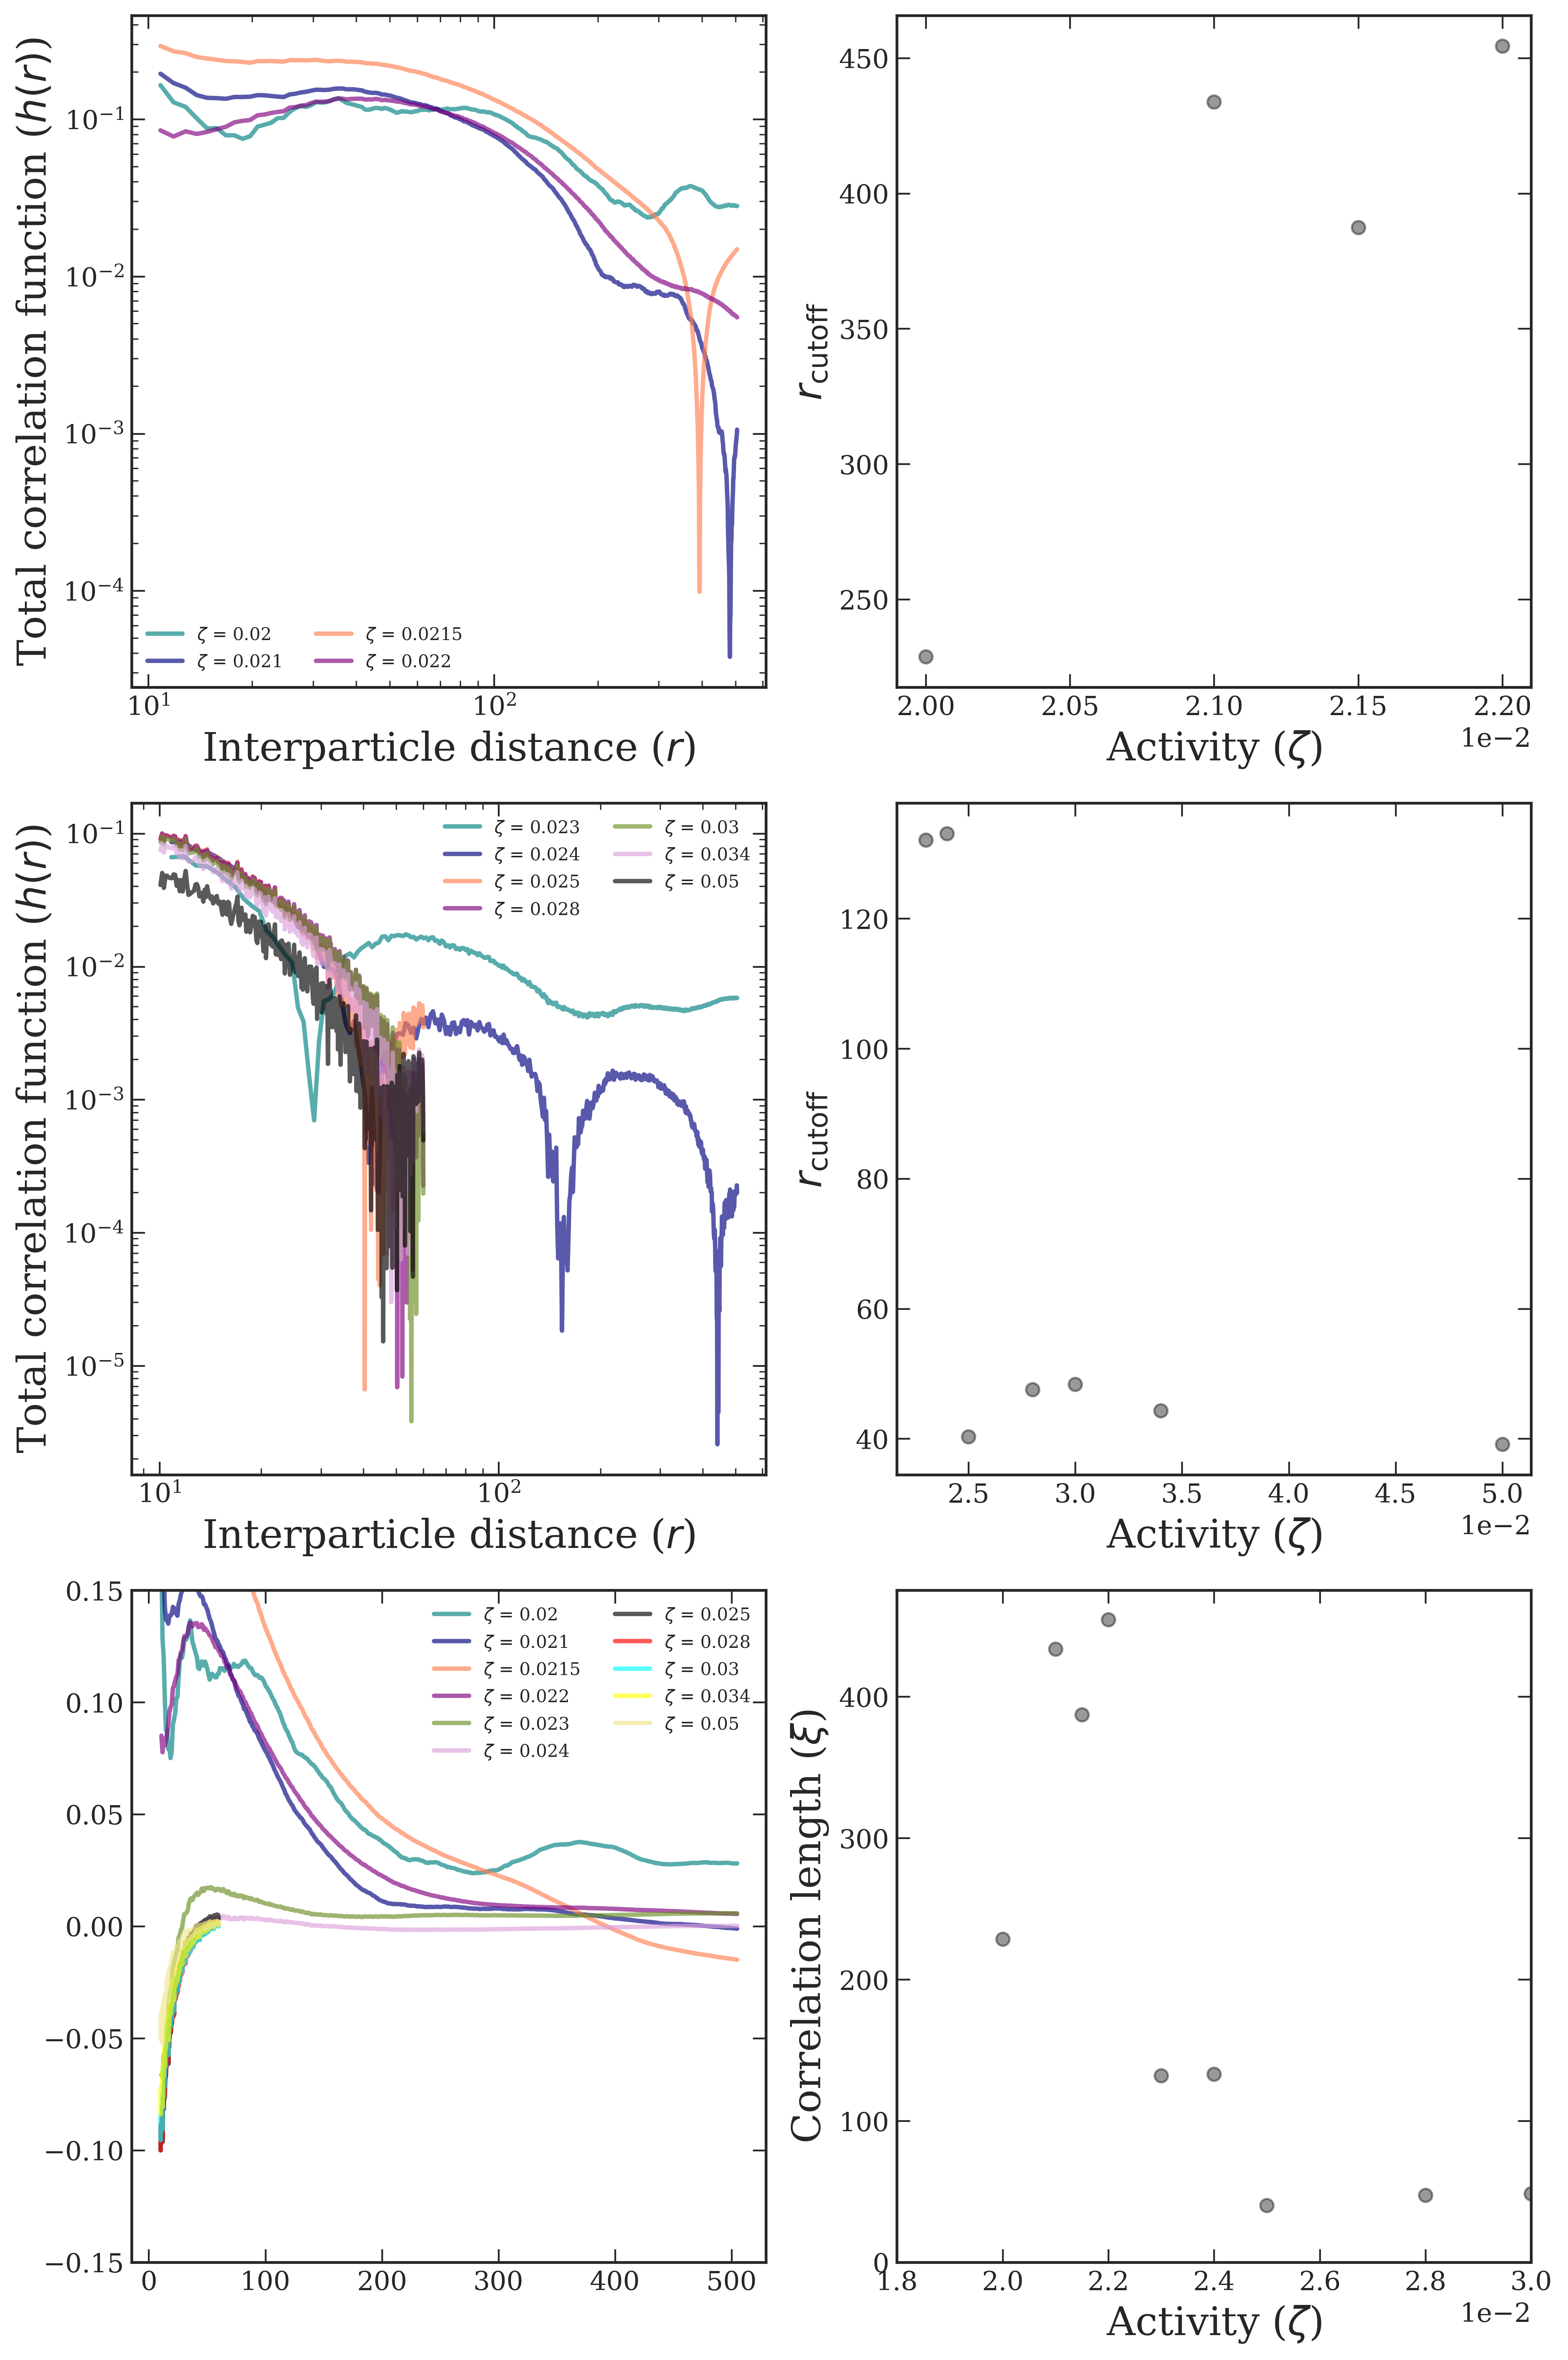

In [268]:
N_list = [-1,-2,]

subscript_list = ['l', '']
rad_idx_list = [40, 20]
rad_list = [50, 10]
act_min, act_max = 0.020, 0.07
fig, ax = plt.subplots(nrows = len(N_list)+1, ncols=2, figsize=(10, 15))  
#ax = ax.flatten()
ff_idx = [500,0, 0]
for j, N in enumerate(N_list):

  data_path = f'X:\\nematic_analysis\\na{LL}\\na{LL}{subscript_list[j]}_pcf'
  act_list = [float(os.listdir(data_path)[i].split('_')[-1]) for i in range(len(os.listdir(data_path)))]

  rad_arr_full, pcf_arr = ad.get_sfac_pcf_full(N)[2:]
  rad_above24 = np.load(os.path.join(ad.output_paths[0], 'rad_above24.npy'))
  use_abs = True
  normalize = False
  cutoff = 1e-3#1e-2

  if j == 0:
     conv_list = np.concatenate([ad.conv_list[-1],ad.conv_list[-2][:2]])
  elif j == 1:
     conv_list = ad.conv_list[-2][2:]
  else:
      conv_list = ad.conv_list[-3]

  activities = act_list[:] #[::2][:-1]

  for i, act in enumerate(activities):

      if act < act_min or act > act_max:
         continue
      
      if N == -2:
        rad_arr = rad_above24 if act > 0.024 else rad_arr_full
      else:
        rad_arr = rad_arr_full
      
      ff_idx = conv_list[i]
      pcf_arr_av = np.nanmean(pcf_arr[ff_idx:], axis = (0,-1)) - 1
      pcf_arr_av_orig = pcf_arr_av.astype('float') 
      pcf_arr_av = np.abs(pcf_arr_av) if use_abs else pcf_arr_av
      pcf_arr_av_std = np.nanstd(pcf_arr[ff_idx:], axis = (0,-1), ddof=1)  \
                        / (np.sqrt(pcf_arr[ff_idx:].shape[0] * pcf_arr.shape[-1]))

      act_idx = act_list.index(act)
      rad_idx_min = rad_idx_list[j]
      rad_kplot_idx = 150
      if N == -2 and act <= 0.024:
        rad_min=rad_list[0]
      else:
        rad_min=rad_list[j]
      rad_idx_min = np.where(rad_arr > rad_min)[0][0]
      #rad_idx_min = 50
      rad_idx_min_norm=np.where(rad_arr > rad_list[-1])[0][0]
      area = trapz(pcf_arr_av[rad_idx_min_norm:, act_idx], rad_arr[rad_idx_min_norm:])
      if normalize:
          pcf_arr_av[rad_idx_min_norm:, act_idx] = pcf_arr_av[rad_idx_min_norm:, act_idx]/ area #pcf_arr_av[rad_idx_min_norm, act_idx]
          pcf_arr_av_std[rad_idx_min_norm:, act_idx] = pcf_arr_av_std[rad_idx_min_norm:, act_idx]/area #pcf_arr_av[rad_idx_min_norm, act_idx]

      ax[j, 0].plot(rad_arr[rad_idx_min_norm:], pcf_arr_av[rad_idx_min_norm:, act_idx], label = rf'$\zeta$ = {act}', alpha=.65)

      if len(np.where(np.abs(pcf_arr_av[rad_idx_min:, act_idx]) - pcf_arr_av_std[rad_idx_min:, act_idx] < cutoff)[0]) == 0:
          rad_cutoff = rad_arr[np.argmin(np.abs(pcf_arr_av[rad_idx_min:, act_idx]) + rad_idx_min)]
          pcf_cutoff = np.min(np.abs((pcf_arr_av[rad_idx_min:, act_idx])))
      else:
        rad_cutoff = rad_arr[np.where(np.abs(pcf_arr_av[rad_idx_min:, act_idx]) - pcf_arr_av_std[rad_idx_min:, act_idx] < cutoff)[0][0] + rad_idx_min]
        pcf_cutoff = cutoff

      ax[j, 1].plot(act, rad_cutoff, 'o', color='k', alpha=.4)
      ax[-1, 0].plot(rad_arr[np.where(rad_arr > rad_list[-1])[0][0]:], 
                     pcf_arr_av_orig[np.where(rad_arr > rad_list[-1])[0][0]:, act_idx], 
                     label = rf'$\zeta$ = {act}', alpha=.65)
      
      alpha=-0.8
      corr_len = -rad_cutoff / np.log(pcf_cutoff * rad_cutoff ** (2+alpha))
      act_res = (act / 0.022 - 1)
      #ax[-1, 1].plot(act, corr_len, 'o', color='k', alpha=.4)
      ax[-1, 1].plot(act, rad_cutoff, 'o', color='k', alpha=.4)
  ax[j, 0].set_ylabel(r'Total correlation function ($h(r)$)')
  ax[j, 0].set_xlabel(r'Interparticle distance ($r$)')
  #ax[j,0].set_xlim([140,50,30][j],[250,130,70][j]);
  #ax[j,0].set_ylim([-.001,-.01,-.01][j],[.005,.0170,.02][j]);
  ax[j, 0].legend(fontsize=8,ncols=2) 
  
  #ax[j,0].set_yscale('log')
  #ax[j,0].set_xscale('log')

  ax[j, 1].set_ylabel(r'$r_{\mathrm{cutoff}}$')
  ax[j, 1].set_xlabel(r'Activity ($\zeta$)');
  ax[j,0].set_yscale('log')
  ax[j,0].set_xscale('log')
ax[-1,1].set_xlim(0.018,0.03)
ax[-1,1].set_ylim(ymin=0)
ax[-1,0].set_ylim(-.15,.15)
ax[-1, 1].set_ylabel(r'Correlation length ($\xi$)')
ax[-1, 1].set_xlabel(r'Activity ($\zeta$)');
#ax[-1,1].text(0.023, 300, r'PRELIMINARY RESULT', fontsize=13)
ax[-1,0].legend(fontsize=8,ncols=2);
#fig.tight_layout()

In [ ]:
av_counts = ad.get_arrays_full(-1,)[-1]
av_counts_diff = np.diff(av_counts, axis = 1)
g_full = av_counts_diff / (dV_arr[None, :, None, None]*av_def[:,0][None, None,:, None])

for i, act in enumerate(act_list):
    av_counts_av = np.nanmean(av_counts[conv_list[i]:,:,i,0], axis=(0)) 
    dav_counts[:, i] = av_counts_av[1:] - av_counts_av[:-1]

g_arr = dav_counts / (dV_arr[:,None]*av_def[:,0][None,:])

fig, ax = plt.subplots()
for i, act in enumerate(act_list):
    gav = np.nanmean(g_full[conv_list[i]:, :, i, :], axis = (0,-1))
    print(gav.shape)
    ax.plot(rad_arr, gav[:]-1, label = f'Activity = {act}')
    ax.legend() 

In [ ]:
av_counts, av_def = ad.get_arrays_av(-1, return_av_counts=True)[-2:]
av_def /= 1024**2
#av_def = ad.get_arrays_av(-1)[-1]
window_sizes = ad.window_sizes[-1]
act_list = ad.act_list[-1]
conv_list = ad.conv_list[-1]
dV_arr = np.pi * (window_sizes[1:]**2 - window_sizes[:-1]**2)
rad_arr = window_sizes[:-1] + (window_sizes[1:] - window_sizes[:-1])/2

dav_counts = np.empty((len(window_sizes)-1, len(act_list))) 
for i, act in enumerate(act_list):
    av_counts_av = np.nanmean(av_counts[conv_list[i]:,:,i,0], axis=(0)) 
    dav_counts[:, i] = av_counts_av[1:] - av_counts_av[:-1]

g_arr = dav_counts / (dV_arr[:,None]*av_def[:,0][None,:])

fig, ax = plt.subplots()
for i, act in enumerate(act_list):
    ax.plot(rad_arr, g_arr[:, i]-1, label = f'Activity = {act}')
    ax.legend() 